# Import the libraries

In [1]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.2 MB/s eta 0:00:00


In [2]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from sklearn import preprocessing
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt import Optimizer
import time
import pandas as pd
import gc
import multiprocessing
from multiprocessing import Process, Queue

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



In [3]:
# Percentage of the dataset that will be used for training
sample_size_low = 0.05 #@param {type:"number"}
sample_size_high = 1 #@param {type:"number"}

# Height and width to which each video will be resized
IMAGE_HEIGHT = 64 #@param {type:"integer"}
IMAGE_WIDTH = 64 #@param {type:"integer"}

# Number of frames of a SINGLE video that will be fed to the model (as a single sequence)
SEQUENCE_LENGTH = 20 #@param {type:"integer"}

# Classes that will be used
CLASSES_LIST = ["Punch", "Skijet", "WalkingWithDog", "HorseRace", "Diving", "PushUps", "Kayaking", "PlayingPiano", "Rowing", "Skiing"]

# The ID of the method that will be employed during sampling
# 0: Simple reservoir sampling in our initial training dataset
# 1: Reservoir sampling in each class based on the number of samples (per class)
sampling_method_id = 1 #@param {type:"integer"}

##################################################
# CONVOLUTIONAL LAYERS INPUT
##################################################
num_of_conv_layers_low = 0 #@param {type:"slider", min:0, max:5, step:1}
num_of_conv_layers_high = 3 #@param {type:"slider", min:1, max:5, step:1}

##################################################
# POOLING LAYERS INPUT
##################################################
num_of_pool_layers_low = 0 #@param {type:"slider", min:0, max:5, step:1}
num_of_pool_layers_high = 3 #@param {type:"slider", min:0, max:5, step:1}

##################################################
# LSTM LAYERS INPUT
##################################################
num_of_lstm_layers_low = 0 #@param {type:"integer"}
num_of_lstm_layers_high = 1 #@param {type:"integer"}

##################################################
# GRU LAYERS INPUT
##################################################
num_of_gru_layers_low = 0 #@param {type:"integer"}
num_of_gru_layers_high = 1 #@param {type:"integer"}

##################################################
# RNN LAYERS INPUT
##################################################
num_of_rnn_layers_low = 0 #@param {type:"integer"}
num_of_rnn_layers_high = 1 #@param {type:"integer"}

##################################################
# DENSE LAYERS INPUT
##################################################
num_of_dense_layers_low = 1 #@param {type:"slider", min:0, max:5, step:1}
num_of_dense_layers_high = 4 #@param {type:"slider", min:1, max:5, step:1}

# Number of epochs for the training process
# One Epoch is when an ENTIRE (training) dataset is passed forward and backward through the neural network only once.
# NOTE: An epoch is comprised of one or more batches.
num_of_epochs_low = 1 #@param {type:"slider", min:1, max:30, step:1}
num_of_epochs_high = 20 #@param {type:"slider", min:1, max:30, step:1}

# The value for the learning rate for the training process (it is inserted to the Adam optimizer)
# During the optimization, the algorithm needs to take a series of tiny steps to descend the error mountain in order to minimize the error.
# The direction of the step is determined by the gradient, while the step size is determined by the learning rate.
lr_low = 1e-3 #@param {type:"number"}
lr_high = 1e-0 #@param {type:"number"}

# The size of the batch for the training process
# Total number of training examples present in a single batch.
# or, number of samples processed before the model is updated.
size_of_batch_low = 32 #@param {type:"integer"}
size_of_batch_high = 64 #@param {type:"integer"}

# Function to minimize over the gaussian prior
# It is used in the Bayesian Opt algorithm
acquisition_f = "gp_hedge" #@param ["LCB", "EI", "PI", "gp_hedge"]

# Maximum training time above which we cancel the experiment (in seconds)
# It is used in the score (accuracy--speed tradeoff) formula
theta_parameter = 10 #@param {type:"integer"}

# Weight for the accuracy of the model. Max value: 0.99
# There is also the weight of training speed of the model (1 - lamda_acc)
# It is used in the score (accuracy--speed tradeoff) formula
lamda_acc = 0.5 #@param {type:"number"}

num_of_calls = 100 #@param {type:"integer"}

CONV_NEURONS_CONST = 16 #@param {type:"integer"}
CONV_NEURONS_BOUND = 64 #@param {type:"integer"}
UNITS_CONST = 32 #@param {type:"integer"}
UNITS_BOUND = 32 #@param {type:"integer"}
DENSE_NEURONS_CONST = 128 #@param {type:"integer"}
DENSE_NEURONS_BOUND = 32 #@param {type:"integer"}


# Download & Visualize our Data

It takes a while...

In [4]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRa

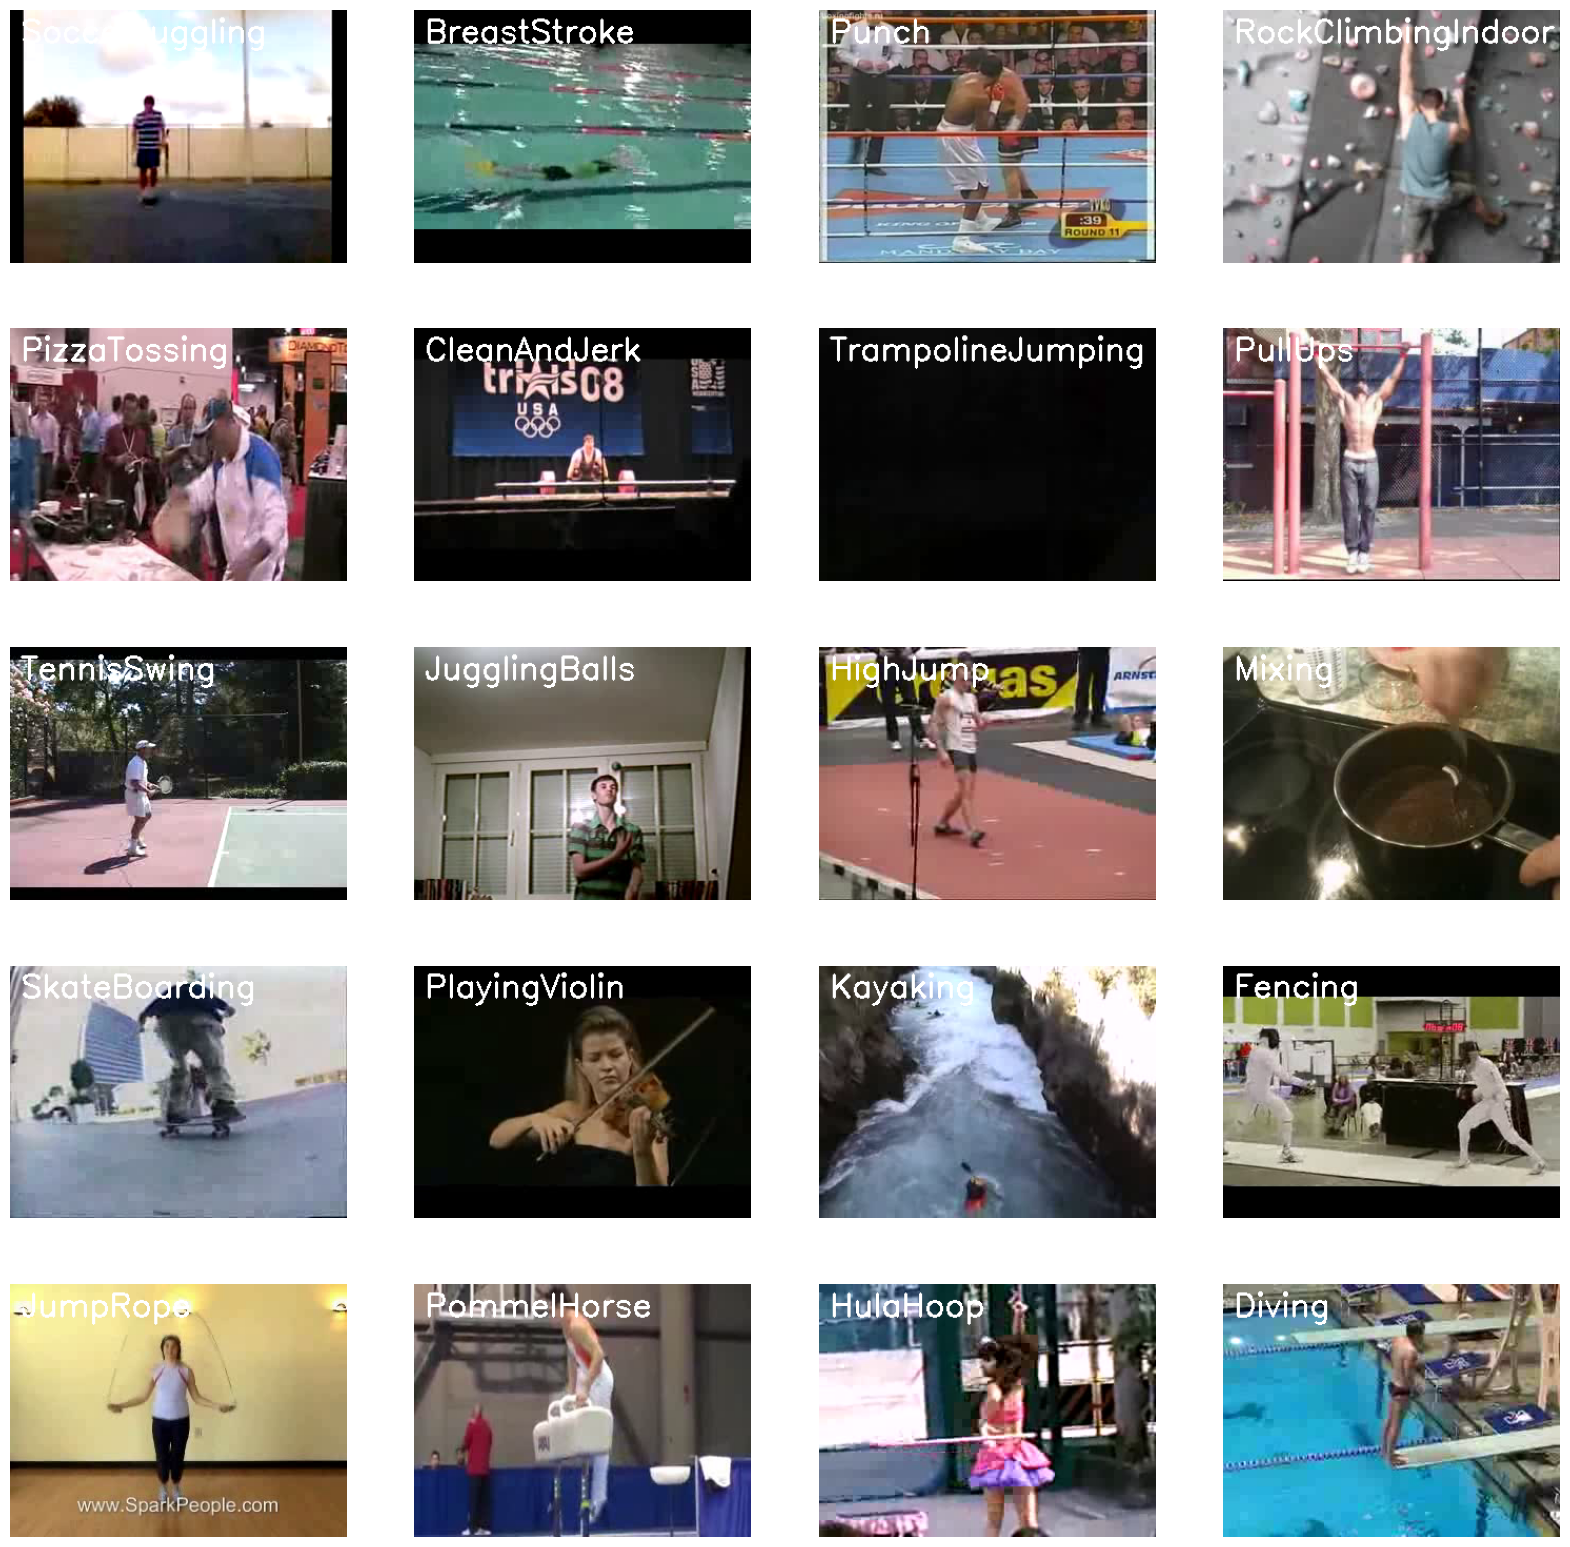

In [5]:
plt.figure(figsize = (20, 20))

# Get the names of all available classes
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random variables (between 0 - #num_of_classes)
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterate over random variables
for counter, random_index in enumerate(random_range, 1):
  # Retrieve the name of the corresponding class
  selected_class_Name = all_classes_names[random_index]

  # Retrieve the list of all videos that are contained in the selected class and select a single one randomly
  video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
  selected_video_file_name = random.choice(video_files_names_list)
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

  # Read the first frame from the selected video
  _, bgr_frame = video_reader.read()
  video_reader.release()

  # Convert frame from BGR to RGB
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # Write the corresponding label
  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

  # Plot the frame
  plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# Pre-process Part

In [6]:
DATASET_DIR = "UCF50"

Function for extracting the required frames from a video after employing resizing and normalization procedures

In [7]:
def frames_extraction(video_path):
  # Store the video frames
  frames_list = []

  # Read the video
  video_reader = cv2.VideoCapture(video_path)

  # Get total number of frames (of this video)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calculate the interval after which frames will be stored (the step)
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  # Iterate over video-frames
  for frame_counter in  range(SEQUENCE_LENGTH):
    # Adjust the pointer of current frame
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # Read the corresponding frame
    success, frame = video_reader.read()

    if not success:
      break

    # Resize-normalize the frame and save it to the corresponding list
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list

Function that creates the dataset that will be used

In [8]:
def create_dataset():
  # Lists that contain the extracted features, the labels and the paths of the videos
  features = []
  labels = []
  video_files_paths = []

  # Iterate through all (selected) classes
  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of Class: {class_name}')

    # Get the videos that are contained in each (selected) class
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
      frames = frames_extraction(video_file_path)
      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  # Convert lists to numpy arrays
  features = np.asarray(features)
  labels = np.asarray(labels)

  return features, labels, video_files_paths


In [9]:
# Create the dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Punch
Extracting Data of Class: Skijet
Extracting Data of Class: WalkingWithDog
Extracting Data of Class: HorseRace
Extracting Data of Class: Diving
Extracting Data of Class: PushUps
Extracting Data of Class: Kayaking
Extracting Data of Class: PlayingPiano
Extracting Data of Class: Rowing
Extracting Data of Class: Skiing


# Split the Data into Train and Test sets

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.25, shuffle = True)

In [11]:
dim_sample_size = Real(low=sample_size_low, high=sample_size_high, name='sample_size')
dim_epochs_number = Integer(low=num_of_epochs_low, high=num_of_epochs_high, name='epochs_number')
# Code 1 -> conv, Code 2 -> pool, Code 3 -> dense, Code 4 -> lstm, Code 5 -> gru, Code 6 -> rnn. We assume that the first layer is conv so dim1 is actualy dim2..
dim_layer_1 = Integer(low=1, high=6, name='dim_1')
dim_layer_2 = Integer(low=1, high=6, name='dim_2')
dim_layer_3 = Integer(low=1, high=6, name='dim_3')
dim_layer_4 = Integer(low=1, high=6, name='dim_4')

dimensions = [dim_sample_size,
              dim_epochs_number,
              dim_layer_1,
              dim_layer_2,
              dim_layer_3,
              dim_layer_4
             ]

default_parameters = [[0.35, 5, 2, 3, 3, 3]]

In [12]:
np.int = int

# Sampling Part

In [13]:
# A function that prints the occurence of each class in a list
def print_times_per_label(lst, labels_all):
  # Get unique labels in our training dataset
  unique_labels = np.unique(labels_all)
  for i in range(0, len(unique_labels)):
    print("Class", unique_labels[i], "has", lst.count(i), "samples in our dataset...")

In [14]:
# A function to randomly select k items from stream[0..n-1].
def reservoir_sampling(stream, n, k):
  i = 0     # index for elements in stream[]

  # reservoir[] is the output array.
  # Initialize it with first k elements from stream[]
  reservoir = [0] * k

  for i in range(k):
    reservoir[i] = stream[i]

  # Iterate from the (k+1)th element to Nth element
  while(i < n):
    # Pick a random index from 0 to i.
    j = random.randrange(i+1)

    # If the randomly picked
    # index is smaller than k,
    # then replace the element
    # present at the index
    # with new element from stream
    if(j < k):
      reservoir[j] = stream[i]
    i+=1

  return reservoir

In [15]:
# A function that finds the size of each reservoir for every class depending on its occurence in the initial dataset
# and returns the unique labels that exist in our dataset along with the corresponding percentage
def reservoir_size_per_class(init_labels):

  # Get unique labels and their counts (how many times they appear) in our training dataset
  unique_labels, counts = np.unique(init_labels, return_counts = True)

  # Transform to list
  unique_labels_lst = unique_labels.tolist()
  counts_lst = counts.tolist()

  perc_per_class = []
  for i in range(len(unique_labels_lst)):
    perc_per_class.append(counts_lst[i]/len(init_labels))

  # print(perc_per_class)

  return perc_per_class, unique_labels_lst

In [16]:
def sampling_method(sampling_method_id, features_train, labels_train, perc_train):
  print("Percentage of filtering in our training dataset was set:")
  print(perc_train)
  print("Pre-sampling training data:")
  print_times_per_label(labels_train.tolist(), np.unique(labels_train))
  if sampling_method_id == 0:
    # Simple reservoir sampling over the whole training dataset
    # Total size of the stream (or training dataset)
    n_train = len(features_train)

    # Number of samples that will be drawn
    k_train = int(n_train * perc_train)

    # Use the indexes of dataset in order to decide which samples will be drawn
    idx_tmp_train_list = list(range(0, n_train))

    # Find the indexes in order to construct the dataset that will be used during the training process
    idx_train = reservoir_sampling(idx_tmp_train_list, n_train, k_train)
  else:
    # Reservoir sampling in each class based on the number of samples (per class) that exist in the initial dataset
    # Find the size of each reservoir for every class depending on its occurence in the initial training dataset
    class_perc, unique_ids = reservoir_size_per_class(labels_train)

    # Stores the indexes (from all classes) in order to construct the dataset that will be used during the training process
    idx_train = []

    # Run for every single class the reservoir sampling seperately
    for i in range(0, len(unique_ids)):
      # Find the locations of each sample belonging to our class of interest
      tmp = np.where(labels_train == unique_ids[i])
      idx_of_class = tmp[0].tolist()

      # Run the reservoir sampling for the class of interest
      sampled_idx_of_class = reservoir_sampling(idx_of_class, len(idx_of_class), int(len(features_train) * perc_train * class_perc[i]))

      # Store the (sampled) samples from this class
      for j in range(0, len(sampled_idx_of_class)):
        idx_train.append(sampled_idx_of_class[j])

  # Store the corresponding images and labels from training dataset based on the sampled indexes
  train_images_lst = []
  for i in idx_train:
    train_images_lst.append(features_train[i])

  train_labels_lst = []
  for i in idx_train:
    train_labels_lst.append(labels_train[i])

  # Check the occurence of each class in the final training dataset
  print("====================================================")
  print("Post-sampling dataset:")
  print_times_per_label(train_labels_lst, labels_train)

  # Tranfsorm the lists that we stored our samples into arrays
  x_train = np.asarray(train_images_lst)
  y_train = np.asarray(train_labels_lst)

  # Verify that the desired filtering was performed in both datasets
  print("====================================================")
  print("Training dataset before sampling:")
  print(features_train.shape)
  print(labels_train.shape)
  print("Training dataset after sampling:")
  print(x_train.shape)
  print(y_train.shape)

  return x_train, y_train

# Create our model

In [17]:
features_train.shape

(984, 20, 64, 64, 3)

In [18]:
def create_model(layers_lst, layer2add, CONV_NEURONS_CONST, UNITS_CONST, DENSE_NEURONS_CONST, CONV_NEURONS_BOUND, UNITS_BOUND, DENSE_NEURONS_BOUND):

  if layers_lst[0] == 'pool' or len(layers_lst) == 0:
    return -1

  # Initialize a sequential model
  model = tf.keras.models.Sequential()

  # Define the number of neurons for conv and dense layers and the number of units for lstm-gru-rnn
  conv_tmp2 = CONV_NEURONS_CONST
  units_tmp2 = UNITS_CONST
  dense_tmp2 = DENSE_NEURONS_CONST

  # Find the type of the next and the previous layer because you need different configurations
  for count, layer in enumerate(layers_lst):
    if count == 0 and len(layers_lst) > 1:
      previous_layer_tmp = 'no'
      next_layer_tmp = layers_lst[count + 1]
    elif count == 0:
      previous_layer_tmp = 'no'
      next_layer_tmp = 'no'
    elif count == len(layers_lst) - 1:
      next_layer_tmp = 'no'
      previous_layer_tmp = layers_lst[count - 1]
    else:
      previous_layer_tmp = layers_lst[count - 1]
      next_layer_tmp = layers_lst[count + 1]

    # Recreate the so-far-model
    # First layer conv
    if layer == 'conv' and count == 0:
      model.add(TimeDistributed(Conv2D(int(conv_tmp2), (3, 3), padding = 'same', activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
      conv_tmp2 = conv_tmp2 * 2
    # First layer lstm-gru-rnn (change the shape of the input) and next or 2-be-added layer lstm-gru-rnn (should add the 'return conf')
    elif ((layer == 'lstm' or layer == 'gru' or layer == 'rnn') and (((count == 0) and len(layers_lst) == 1 and (layer2add == 'lstm' or layer2add == 'gru' or layer2add == 'rnn')) or ((count == 0) and (next_layer_tmp == 'lstm' or next_layer_tmp == 'gru' or next_layer_tmp == 'rnn')))):
      if layer == 'lstm':
        model.add(tf.keras.layers.LSTM(int(units_tmp2), return_sequences = True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      elif layer == 'gru':
        model.add(tf.keras.layers.GRU(int(units_tmp2), return_sequences = True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      else:
        model.add(tf.keras.layers.SimpleRNN(int(units_tmp2), return_sequences = True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      units_tmp2 = units_tmp2 / 2
    # First layer lstm-gru-rnn (change the shape of the input)
    elif ((layer == 'lstm' or layer == 'gru' or layer == 'rnn') and count == 0):
      if layer == 'lstm':
        model.add(tf.keras.layers.LSTM(int(units_tmp2), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      elif layer == 'gru':
        model.add(tf.keras.layers.GRU(int(units_tmp2), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      else:
        model.add(tf.keras.layers.SimpleRNN(int(units_tmp2), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT * IMAGE_WIDTH * 3)))
      units_tmp2 = units_tmp2 / 2
    # First layer densse (change the shape of the input)
    elif layer == 'dense' and count == 0:
      model.add(tf.keras.layers.Dense(int(dense_tmp2), activation='relu', input_shape=(SEQUENCE_LENGTH * IMAGE_HEIGHT * IMAGE_WIDTH * 3,)))
      dense_tmp2 = dense_tmp2 / 2
    # For the remaining layers
    else:
      if layer == 'conv':
        # Add a conv layer by doubling its neurons if they do not violate our user-defined bound
        if conv_tmp2 <= CONV_NEURONS_BOUND:
          model.add(TimeDistributed(Conv2D(int(conv_tmp2), (3, 3), padding = 'same', activation='relu')))
          conv_tmp2 = conv_tmp2 * 2
        else:
          model.add(TimeDistributed(Conv2D(int(CONV_NEURONS_BOUND), (3, 3), padding = 'same', activation='relu')))
          conv_tmp2 = CONV_NEURONS_BOUND
      elif layer == 'pool':
        # Add a pool layer
        model.add(TimeDistributed(MaxPooling2D((4, 4))))
      elif layer == 'lstm':
        # If the previous layer is conv or pool add a flatten layer first
        if previous_layer_tmp == 'conv' or previous_layer_tmp == 'pool':
          model.add(TimeDistributed(BatchNormalization()))
          model.add(TimeDistributed(Flatten()))
        # Add a lstm layer by reducing (* 0.5) its units if they do not violate our user-defined bound
        if units_tmp2 >= UNITS_BOUND:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.LSTM(int(units_tmp2)))
          else:
            model.add(tf.keras.layers.LSTM(int(units_tmp2), return_sequences = True))
          units_tmp2 = units_tmp2 / 2
        else:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.LSTM(int(UNITS_BOUND)))
          else:
            model.add(tf.keras.layers.LSTM(int(UNITS_BOUND), return_sequences = True))
          units_tmp2 = UNITS_BOUND
      elif layer == 'gru':
        # If the previous layer is conv or pool add a flatten layer first
        if previous_layer_tmp == 'conv' or previous_layer_tmp == 'pool':
          model.add(TimeDistributed(BatchNormalization()))
          model.add(TimeDistributed(Flatten()))
        # Add a gru layer by reducing (* 0.5) its units if they do not violate our user-defined bound
        if units_tmp2 >= UNITS_BOUND:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.GRU(int(units_tmp2)))
          else:
            model.add(tf.keras.layers.GRU(int(units_tmp2), return_sequences = True))
          units_tmp2 = units_tmp2 / 2
        else:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.GRU(int(UNITS_BOUND)))
          else:
            model.add(tf.keras.layers.GRU(int(UNITS_BOUND), return_sequences = True))
          units_tmp2 = UNITS_BOUND
      elif layer == 'rnn':
        # If the previous layer is conv or pool add a flatten layer first
        if previous_layer_tmp == 'conv' or previous_layer_tmp == 'pool':
          model.add(TimeDistributed(BatchNormalization()))
          model.add(TimeDistributed(Flatten()))
        # Add a rnn layer by reducing (* 0.5) its units if they do not violate our user-defined bound
        if units_tmp2 >= UNITS_BOUND:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.SimpleRNN(int(units_tmp2)))
          else:
            model.add(tf.keras.layers.SimpleRNN(int(units_tmp2), return_sequences = True))
          units_tmp2 = units_tmp2 / 2
        else:
          # If the next layer is dense then do not return sequences
          if next_layer_tmp == 'dense' or (layer2add == 'dense' and count == len(layers_lst) - 1):
            model.add(tf.keras.layers.SimpleRNN(int(UNITS_BOUND)))
          else:
            model.add(tf.keras.layers.SimpleRNN(int(UNITS_BOUND), return_sequences = True))
          units_tmp2 = UNITS_BOUND
      else:
        if previous_layer_tmp == 'conv' or previous_layer_tmp == 'pool':
          model.add(Flatten())
        # Add a dense layer by reducing (* 0.5) its neurons if they do not violate our user-defined bound
        if dense_tmp2 >= DENSE_NEURONS_BOUND:
          model.add(tf.keras.layers.Dense(int(dense_tmp2), activation='relu'))
          dense_tmp2 = dense_tmp2 / 2
        else:
          model.add(tf.keras.layers.Dense(int(DENSE_NEURONS_BOUND), activation='relu'))
          dense_tmp2 = DENSE_NEURONS_BOUND

  return model, conv_tmp2, units_tmp2, dense_tmp2

# Black Box function

In [19]:
def my_evaluate(q, x_train, y_train, features_test, labels_test, layers_lst, epochs_number, learning_rate, batch_size, CONV_NEURONS_CONST, UNITS_CONST, DENSE_NEURONS_CONST, CONV_NEURONS_BOUND, UNITS_BOUND, DENSE_NEURONS_BOUND):
  error_flag = -1

  try:
    # Function that creates the model
    model, *_ = create_model(layers_lst, 'dense', CONV_NEURONS_CONST, UNITS_CONST, DENSE_NEURONS_CONST, CONV_NEURONS_BOUND, UNITS_BOUND, DENSE_NEURONS_BOUND)

    if model == -1:
      return -1000000

    # If the just-added-layer was conv or pool then add manually a flatten layer
    if 'lstm' not in layers_lst and 'gru' not in layers_lst and 'rnn' not in layers_lst and 'dense' not in layers_lst:
      model.add(Flatten())

    # Softmax is an activation function that is used mainly for classification tasks
    # It normalizes the input vector into a probability distribution  that is proportional to the exponential of the input numbers.
    model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation = "softmax"))
  except ValueError:
    print("No valid input...:(")
    error_flag = 1

  if error_flag == -1:
    model.compile(optimizer=Adam(learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    model.summary()

    # Here we reshape the input of the network based on the type of the first layer of the network
    # If the first layer is conv
    if layers_lst[0] == 'conv':
      reshaped_x_train = x_train
      reshaped_x_test = features_test
    # If the first layer is lstm-gru-rnn
    elif layers_lst[0] == 'lstm' or layers_lst[0] == 'gru' or layers_lst[0] == 'rnn':
      num_samples, num_frames, height, width, channels = x_train.shape
      reshaped_x_train = x_train.reshape(num_samples, num_frames, height * width * channels)
      num_samples, num_frames, height, width, channels = features_test.shape
      reshaped_x_test = features_test.reshape(num_samples, num_frames, height * width * channels)
    # If the first layer is dense
    else:
      num_samples, num_frames, height, width, channels = x_train.shape
      reshaped_x_train = x_train.reshape(num_samples, num_frames * height * width * channels)
      num_samples, num_frames, height, width, channels = features_test.shape
      reshaped_x_test = features_test.reshape(num_samples, num_frames * height * width * channels)
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    print(reshaped_x_train.shape)
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    start = time.time()
    np.int = int
    blackbox = model.fit(x=reshaped_x_train,
                        y=y_train,
                        epochs=epochs_number,
                        batch_size=batch_size
                        )
    stop = time.time()

    # Compute the training speed of this CNN architecture
    tr_time = stop - start

    # Compute the accuracy of our training model in the testing dataset
    test_loss, test_acc = model.evaluate(reshaped_x_test,  labels_test, verbose=2)

    # # Return the validation accuracy for the last epoch.
    # accuracy = blackbox.history['val_accuracy'][-1]

    # Compute the metric that captures the accuracy--speed tradeoff
    # tradeOff_metric = lamda_acc * test_acc - (1 - lamda_acc) * math.tanh(tr_time/theta_parameter - 1)

    # Linear formula
    # tradeOff_metric = lamda_acc * test_acc + (1 - lamda_acc) * (1 - min(1, tr_time/theta_parameter))

    # Multiplicative formula
    # tradeOff_metric = test_acc ** lamda_acc * (1 - min(1, tr_time/theta_parameter)) ** (1 - lamda_acc)

    # Harmonic mean
    # tradeOff_metric = (2 * test_acc * (1 - min(1, tr_time/theta_parameter))) / (test_acc + 1 - min(1, tr_time/theta_parameter) + 1e-5)

    # Sigmoid
    # tradeOff_metric = (1 / (1 + np.exp(-test_acc))) * (1 - 1 / (1 + np.exp(-min(1, tr_time/theta_parameter))))

    # Piecewise
    # tradeOff_metric = test_acc if tr_time <= theta_parameter else test_acc * max(0, 1 - 0.5 * (tr_time - theta_parameter))

    # F1 like
    # alpha = 2
    # tradeOff_metric = ((1 + alpha**2) * test_acc * min(1, tr_time/theta_parameter)) / (alpha ** 2 * test_acc + min(1, tr_time/theta_parameter))

    # Exp decay penalty
    # tradeOff_metric = test_acc * np.exp(-0.5 * min(1, tr_time/theta_parameter))

    # inverse additive penalty
    tradeOff_metric = test_acc / (1 + 0.5 * min(1, tr_time/theta_parameter))

    # min-based tradeoff
    # tradeOff_metric = min(test_acc, min(1, tr_time/theta_parameter))

    # product with complement
    # tradeOff_metric = test_acc * (1 - min(1, tr_time/theta_parameter))

    # square root compensation
    # tradeOff_metric = np.sqrt(test_acc) * np.sqrt(1 - min(1, tr_time/theta_parameter))

    # jacard style normalization
    # tradeOff_metric = test_acc * (1 - min(1, tr_time/theta_parameter)) / (test_acc + (1 - min(1, tr_time/theta_parameter)) - test_acc * (1 - min(1, tr_time/theta_parameter)))

    # log-sigmoid dominance
    # tradeOff_metric = 1 / (1 + np.exp(-0.5 * (test_acc - (1 - min(1, tr_time/theta_parameter)))))

    # Print the results.
    print()
    print("Accuracy (on the testing dataset): {0:.2%}".format(test_acc))
    print(f"Training time: ", tr_time)
    print(tradeOff_metric)
    print()

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    q.put([test_acc, tr_time, tradeOff_metric])
  else:
    q.put([0, 1000000000, -100000])


In [20]:
@use_named_args(dimensions = dimensions)
def fitness(sample_size, epochs_number, dim_1, dim_2, dim_3, dim_4):

    layer_lst = []
    layer_lst.append(dim_1)
    layer_lst.append(dim_2)
    layer_lst.append(dim_3)
    layer_lst.append(dim_4)

    print()
    print(layer_lst)
    print()

    flag = False
    for i in range(0, len(layer_lst)):
      if flag == False and layer_lst[i] == 3:
        flag = True
      if flag == True and (layer_lst[i] != 3):
        print('Invalid Architecture!!!')
        extra_results.append([-1, -1])
        return 100000

    layers_lst = ['conv']
    for i in range(0, len(layer_lst)):
      if layer_lst[i] == 1:
        layers_lst.append('conv')
      elif layer_lst[i] == 2:
        layers_lst.append('pool')
      elif layer_lst[i] == 4:
        layers_lst.append('lstm')
      elif layer_lst[i] == 5:
        layers_lst.append('gru')
      elif layer_lst[i] == 6:
        layers_lst.append('rnn')
      else:
        layers_lst.append('dense')
    #layers_lst.append('dense')

    learning_rate = 0.001
    batch_size = 10

    # Call the sampling method
    x_train, y_train = sampling_method(sampling_method_id, features_train, labels_train, sample_size)

    # layers_lst = []
    # if conv_number > 0:
    #   if conv_number > pool_number:
    #     for i in range(0, conv_number - pool_number):
    #       layers_lst.append('conv')
    #     for i in range(0, pool_number):
    #       layers_lst.append('conv')
    #       layers_lst.append('pool')
    #   elif conv_number == pool_number:
    #     for i in range(0, conv_number):
    #       layers_lst.append('conv')
    #       layers_lst.append('pool')
    #   else:
    #     for i in range(0, conv_number):
    #       layers_lst.append('conv')
    #       layers_lst.append('pool')
    #     for i in range(conv_number, pool_number):
    #       layers_lst.append('pool')
    # if lstm_number > 0:
    #   for i in range(0, lstm_number):
    #     layers_lst.append('lstm')
    # if gru_number > 0:
    #   for i in range(0, gru_number):
    #     layers_lst.append('gru')
    # if rnn_number > 0:
    #   for i in range(0, rnn_number):
    #     layers_lst.append('rnn')
    # if dense_number > 0:
    #   for i in range(0, dense_number):
    #     layers_lst.append('dense')

    print(f"---------------------------->{layers_lst}")

    q = Queue()
    process_eval = multiprocessing.Process(target=my_evaluate, args=(q, x_train, y_train, features_test, labels_test, layers_lst, epochs_number, learning_rate, batch_size, CONV_NEURONS_CONST, UNITS_CONST, DENSE_NEURONS_CONST, CONV_NEURONS_BOUND, UNITS_BOUND, DENSE_NEURONS_BOUND))
    process_eval.start()
    test_acc, tr_time, tradeOff_metric = q.get()
    process_eval.join()

    # Print the results.
    print()
    print("Accuracy (on the testing dataset): {0:.2%}".format(test_acc))
    print(f"Training time: ", tr_time)
    print(tradeOff_metric)
    print()

    # Store the accuracy and the training speed of the corresponding model in order to be printed in the final cell
    tmp = [test_acc, tr_time]
    extra_results.append(tmp)

    # Delete the Keras model with these hyper-parameters from memory.
    K.clear_session()
    gc.collect()
    del x_train
    del y_train

    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    tf.compat.v1.reset_default_graph()

    return -tradeOff_metric

In [21]:
K.clear_session()
tf.compat.v1.reset_default_graph()

In [22]:
global extra_results
extra_results = []

# Bayes Optimization

In [23]:
start_program = time.time()

In [24]:
# gp_result = gp_minimize(func=fitness,
#                             dimensions = dimensions,
#                             n_calls = num_of_calls,
#                             acq_func = acquisition_f,
#                             noise = "gaussian",
#                             n_jobs = -1,
#                             x0 = default_parameters)

# Initialize the optimizer
opt = Optimizer(
    dimensions=dimensions,
    base_estimator="GP",
    acq_func="LCB",  # Encourages exploration/exploitation trade-off
    acq_func_kwargs={'kappa': 1000}  # Higher kappa = more exploration
)

# Initial points if you have them
if default_parameters:
    for x in default_parameters:
        opt.tell(x, fitness(x), fit = True)

# Convergence parameters
max_iter = 10000  # Optional cap
convergence_window = 20  # Number of iterations to consider
tolerance = 1e-4  # Minimum improvement

prev_best = float('inf')
no_improve_counter = 0

for i in range(max_iter):
    next_x = opt.ask()
    next_y = fitness(next_x)
    opt.tell(next_x, next_y, fit = True)

    curr_best = np.min(opt.yi)
    improvement = prev_best - curr_best

    if improvement < tolerance:
        no_improve_counter += 1
    else:
        no_improve_counter = 0
        prev_best = curr_best

    if no_improve_counter >= convergence_window:
        print(f"Converged after {i+1} iterations.")
        break

# Result
best_index = np.argmin(opt.yi)
best_params = opt.Xi[best_index]
best_score = opt.yi[best_index]


[2, 3, 3, 3]

Percentage of filtering in our training dataset was set:
0.35
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 43 samples in our dataset...
Class 1 has 26 samples in our dataset...
Class 2 has 31 samples in our dataset...
Class 3 has 30 samples in our dataset...
Class 4 has 38 samples in our dataset...
Class 5 has 28 samples in our dataset...
Class 6 has 40 samples in our dataset...
Class 7 has 26 samples in our dataset...
Class 8 has 37 samples in our dataset...
Class 9 has 40 samples in our dataset...
Training dataset before sampling:
(984, 20, 64,

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,485,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,497,002 (40.04 MB)

 Trainable params: 10,497,002 (40.04 MB)

 Non-trainable params: 0 (0.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(339, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/5


  output, from_logits = _get_logits(



34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 0.1039 - loss: 9.1982
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2576 - loss: 2.0461
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4921 - loss: 1.4566
Epoch 4/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6997 - loss: 0.9755
Epoch 5/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7999 - loss: 0.6102
11/11 - 4s - 367ms/step - accuracy: 0.4970 - loss: 1.4695

Accuracy (on the testing dataset): 49.70%
Training time:  18.832174062728882
0.3313008149464925


Accuracy (on the testing dataset): 49.70%
Training time:  18.832174062728882
0.3313008149464925


[np.int64(4), np.int64(2), np.int64(3), np.int64(3)]

Percentage of filtering in our training dataset was set:
0.29239483041887115
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 h

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(1), np.int64(1), np.int64(6), np.int64(3)]

Percentage of filtering in our training dataset was set:
0.7119541850937963
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 87 samples in our dataset...
Class 1 has 54 samples in our dataset...
Class 2 has 64 samples in our dataset...
Class 3 has 61 samples in our dataset...
Class 4 has 79 samples in our dataset...
Class 5 has 57 samples in our dataset...
Class 6 has 81 samples in our dataset...
Class 7 has 54 sam

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 64, 64, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 64, 64, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 262144)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │     8,389,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,419,018 (32.12 MB)

 Trainable params: 8,418,890 (32.12 MB)

 Non-trainable params: 128 (512.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(696, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/15


  output, from_logits = _get_logits(



70/70 ━━━━━━━━━━━━━━━━━━━━ 50s 357ms/step - accuracy: 0.2201 - loss: 2.2445
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.3088 - loss: 1.9573
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.3677 - loss: 1.9062
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.3373 - loss: 1.8576
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.3268 - loss: 1.8852
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.3340 - loss: 1.8168
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.3283 - loss: 1.8646
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.3342 - loss: 1.8626
Epoch 9/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.3017 - loss: 1.8762
Epoch 10/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.3609 - loss: 1.7799
Epoch 11/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.3840 - loss: 1.8086
Epoch 12/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accura

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 64, 64, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 64, 64, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 262144)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 20, 32)         │    25,169,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,199,594 (96.13 MB)

 Trainable params: 25,199,466 (96.13 MB)

 Non-trainable params: 128 (512.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(527, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/10


  output, from_logits = _get_logits(



53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 274ms/step - accuracy: 0.1844 - loss: 2.2095
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.3308 - loss: 1.9361
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.3171 - loss: 1.8868
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.3737 - loss: 1.7666
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - accuracy: 0.3523 - loss: 1.8568
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - accuracy: 0.3652 - loss: 1.6995
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - accuracy: 0.3435 - loss: 1.7161
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - accuracy: 0.4748 - loss: 1.6188
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 271ms/step - accuracy: 0.3787 - loss: 1.7855
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 272ms/step - accuracy: 0.4194 - loss: 1.6161
11/11 - 3s - 281ms/step - accuracy: 0.2195 - loss: 2.1363

Accuracy (on the testing dataset): 21.95%
Training time:  158.1745662689209
0.146

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(3), np.int64(2), np.int64(4), np.int64(2)]

Invalid Architecture!!!

[np.int64(2), np.int64(5), np.int64(1), np.int64(1)]

Percentage of filtering in our training dataset was set:
0.5700871162498417
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 70 samples in our dataset...
Class 1 has 43 samples in our dataset...
Class 2 has 51 samples in our dataset...
Class 3 has 49 samples in our dataset...
Class 4 has 63 samples in our dataset...
Class 5 has 46 sample

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(2), np.int64(3), np.int64(2), np.int64(1)]

Invalid Architecture!!!

[np.int64(4), np.int64(5), np.int64(4), np.int64(2)]

Percentage of filtering in our training dataset was set:
0.5434668871285361
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 66 samples in our dataset...
Class 1 has 41 samples in our dataset...
Class 2 has 48 samples in our dataset...
Class 3 has 46 samples in our dataset...
Class 4 has 60 samples in our dataset...
Class 5 has 44 sample

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(6), np.int64(1), np.int64(1), np.int64(1)]

Percentage of filtering in our training dataset was set:
0.05
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 6 samples in our dataset...
Class 1 has 3 samples in our dataset...
Class 2 has 4 samples in our dataset...
Class 3 has 4 samples in our dataset...
Class 4 has 5 samples in our dataset...
Class 5 has 4 samples in our dataset...
Class 6 has 5 samples in our dataset...
Class 7 has 3 samples in our dataset...

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(3), np.int64(6), np.int64(1), np.int64(6)]

Invalid Architecture!!!

[np.int64(6), np.int64(6), np.int64(1), np.int64(3)]

Percentage of filtering in our training dataset was set:
0.9223369477172851
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 113 samples in our dataset...
Class 1 has 70 samples in our dataset...
Class 2 has 83 samples in our dataset...
Class 3 has 79 samples in our dataset...
Class 4 has 102 samples in our dataset...
Class 5 has 74 samp

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(6), np.int64(6), np.int64(1), np.int64(6)]

Percentage of filtering in our training dataset was set:
0.05
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 6 samples in our dataset...
Class 1 has 3 samples in our dataset...
Class 2 has 4 samples in our dataset...
Class 3 has 4 samples in our dataset...
Class 4 has 5 samples in our dataset...
Class 5 has 4 samples in our dataset...
Class 6 has 5 samples in our dataset...
Class 7 has 3 samples in our dataset...

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(4), np.int64(4), np.int64(5), np.int64(5)]

Percentage of filtering in our training dataset was set:
0.6008166406873306
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 73 samples in our dataset...
Class 1 has 45 samples in our dataset...
Class 2 has 54 samples in our dataset...
Class 3 has 51 samples in our dataset...
Class 4 has 66 samples in our dataset...
Class 5 has 48 samples in our dataset...
Class 6 has 69 samples in our dataset...
Class 7 has 46 sam

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 65536)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 32)         │     8,392,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 20, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,414,666 (32.10 MB)

 Trainable params: 8,414,634 (32.10 MB)

 Non-trainable params: 32 (128.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(586, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/19


  output, from_logits = _get_logits(



59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.2429 - loss: 2.1481
Epoch 2/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.4376 - loss: 1.6750
Epoch 3/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5042 - loss: 1.4311
Epoch 4/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5709 - loss: 1.2606
Epoch 5/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.6084 - loss: 1.1477
Epoch 6/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6698 - loss: 1.1019
Epoch 7/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5898 - loss: 1.1785
Epoch 8/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6193 - loss: 1.0376
Epoch 9/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.6398 - loss: 1.1290
Epoch 10/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6590 - loss: 0.9950
Epoch 11/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7413 - loss: 0.8452
Epoch 12/19
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7092 - 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 65536)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 20, 32)         │     6,294,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 20, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 20, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,314,570 (24.09 MB)

 Trainable params: 6,314,538 (24.09 MB)

 Non-trainable params: 32 (128.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(192, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/19


  output, from_logits = _get_logits(



20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.2562 - loss: 2.1733
Epoch 2/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.3851 - loss: 1.8562
Epoch 3/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5112 - loss: 1.6039
Epoch 4/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5669 - loss: 1.4233
Epoch 5/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6933 - loss: 1.2162
Epoch 6/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6347 - loss: 1.0987
Epoch 7/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7209 - loss: 0.9090
Epoch 8/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7449 - loss: 0.8793
Epoch 9/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.8067 - loss: 0.7429
Epoch 10/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8428 - loss: 0.6363
Epoch 11/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8097 - loss: 0.6294
Epoch 12/19
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8329 - 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 16, 16, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 64) │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 327680)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │     3,276,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,337,322 (12.73 MB)

 Trainable params: 3,337,322 (12.73 MB)

 Non-trainable params: 0 (0.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(959, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/4


  output, from_logits = _get_logits(



96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.2724 - loss: 2.2254
Epoch 2/4
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6282 - loss: 1.1022
Epoch 3/4
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8348 - loss: 0.5518
Epoch 4/4
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9079 - loss: 0.2809
11/11 - 5s - 488ms/step - accuracy: 0.7683 - loss: 0.7172

Accuracy (on the testing dataset): 76.83%
Training time:  40.75374174118042
0.5121951103210449


Accuracy (on the testing dataset): 76.83%
Training time:  40.75374174118042
0.5121951103210449


[np.int64(2), np.int64(4), np.int64(2), np.int64(3)]

Percentage of filtering in our training dataset was set:
0.610625873380542
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 11

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(6), np.int64(6), np.int64(5), np.int64(5)]

Percentage of filtering in our training dataset was set:
0.24264361978657706
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 29 samples in our dataset...
Class 1 has 18 samples in our dataset...
Class 2 has 21 samples in our dataset...
Class 3 has 20 samples in our dataset...
Class 4 has 26 samples in our dataset...
Class 5 has 19 samples in our dataset...
Class 6 has 27 samples in our dataset...
Class 7 has 18 sa

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 65536)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 20, 32)         │     2,098,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 20, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113,802 (8.06 MB)

 Trainable params: 2,113,770 (8.06 MB)

 Non-trainable params: 32 (128.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(232, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/15


  output, from_logits = _get_logits(



24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.1926 - loss: 2.2337
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4389 - loss: 1.8709
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.4943 - loss: 1.7260
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.4946 - loss: 1.5606
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5767 - loss: 1.3388
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.5943 - loss: 1.2492
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6992 - loss: 1.1035
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6432 - loss: 1.0414
Epoch 9/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7042 - loss: 1.0058
Epoch 10/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.6721 - loss: 0.9165
Epoch 11/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7993 - loss: 0.7633
Epoch 12/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.800

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 65536)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 20, 32)         │     2,098,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 20, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 20, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,118,058 (8.08 MB)

 Trainable params: 2,118,026 (8.08 MB)

 Non-trainable params: 32 (128.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(948, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/14


  output, from_logits = _get_logits(



95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.2409 - loss: 2.0523
Epoch 2/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.4988 - loss: 1.4838
Epoch 3/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5555 - loss: 1.2596
Epoch 4/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.5931 - loss: 1.1136
Epoch 5/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.6128 - loss: 1.0275
Epoch 6/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.7000 - loss: 0.8904
Epoch 7/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.7130 - loss: 0.8877
Epoch 8/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.7069 - loss: 0.8096
Epoch 9/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.6989 - loss: 0.8315
Epoch 10/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.7784 - loss: 0.6517
Epoch 11/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.7538 - loss: 0.6738
Epoch 12/14
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.7682 -

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 65536)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 20, 32)         │     6,294,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,301,802 (24.04 MB)

 Trainable params: 6,301,770 (24.04 MB)

 Non-trainable params: 32 (128.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(974, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/14


  output, from_logits = _get_logits(



98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - accuracy: 0.2441 - loss: 2.0783
Epoch 2/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.3515 - loss: 1.7617
Epoch 3/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.3960 - loss: 1.6710
Epoch 4/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.4723 - loss: 1.5940
Epoch 5/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.4642 - loss: 1.5731
Epoch 6/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.5189 - loss: 1.4548
Epoch 7/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.4969 - loss: 1.4353
Epoch 8/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.5331 - loss: 1.3454
Epoch 9/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.5324 - loss: 1.3222
Epoch 10/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.5492 - loss: 1.3053
Epoch 11/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.5793 - loss: 1.2447
Epoch 12/14
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/ste

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(2), np.int64(4), np.int64(6), np.int64(1)]

Percentage of filtering in our training dataset was set:
0.3321814145453207
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 40 samples in our dataset...
Class 1 has 25 samples in our dataset...
Class 2 has 29 samples in our dataset...
Class 3 has 28 samples in our dataset...
Class 4 has 36 samples in our dataset...
Class 5 has 26 samples in our dataset...
Class 6 has 38 samples in our dataset...
Class 7 has 25 sam

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(6), np.int64(4), np.int64(3), np.int64(6)]

Invalid Architecture!!!

[np.int64(6), np.int64(3), np.int64(4), np.int64(1)]

Invalid Architecture!!!

[np.int64(6), np.int64(5), np.int64(2), np.int64(6)]

Percentage of filtering in our training dataset was set:
0.25441746332522214
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 31 samples in our dataset...
Class 1 has 19 samples in our dataset...
Class 2 has 22 samples in our dataset...
Class 3 has 21 samples 

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(6), np.int64(5), np.int64(5), np.int64(6)]

Percentage of filtering in our training dataset was set:
0.05000015210744759
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 6 samples in our dataset...
Class 1 has 3 samples in our dataset...
Class 2 has 4 samples in our dataset...
Class 3 has 4 samples in our dataset...
Class 4 has 5 samples in our dataset...
Class 5 has 4 samples in our dataset...
Class 6 has 5 samples in our dataset...
Class 7 has 3 samples in

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 65536)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 20, 32)         │     2,098,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 20, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 20, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113,802 (8.06 MB)

 Trainable params: 2,113,770 (8.06 MB)

 Non-trainable params: 32 (128.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(44, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


  output, from_logits = _get_logits(



5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - accuracy: 0.1504 - loss: 2.4008
11/11 - 2s - 154ms/step - accuracy: 0.1128 - loss: 2.2531

Accuracy (on the testing dataset): 11.28%
Training time:  12.459884405136108
0.0752032498518626


Accuracy (on the testing dataset): 11.28%
Training time:  12.459884405136108
0.0752032498518626


[np.int64(1), np.int64(6), np.int64(6), np.int64(1)]

Percentage of filtering in our training dataset was set:
0.9999999985594157
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 122 samples in our dataset...
Class 1 has 75 samples in our dat

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(3), np.int64(3), np.int64(1), np.int64(6)]

Invalid Architecture!!!

[np.int64(6), np.int64(1), np.int64(6), np.int64(1)]

Percentage of filtering in our training dataset was set:
0.05
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 6 samples in our dataset...
Class 1 has 3 samples in our dataset...
Class 2 has 4 samples in our dataset...
Class 3 has 4 samples in our dataset...
Class 4 has 5 samples in our dataset...
Class 5 has 4 samples in our dataset...


  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(1), np.int64(6), np.int64(5), np.int64(6)]

Percentage of filtering in our training dataset was set:
0.11009977763460657
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 13 samples in our dataset...
Class 1 has 8 samples in our dataset...
Class 2 has 9 samples in our dataset...
Class 3 has 9 samples in our dataset...
Class 4 has 12 samples in our dataset...
Class 5 has 8 samples in our dataset...
Class 6 has 12 samples in our dataset...
Class 7 has 8 samples

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 64, 64, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 131072)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 20, 32)         │     4,195,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 20, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,209,322 (16.06 MB)

 Trainable params: 4,209,258 (16.06 MB)

 Non-trainable params: 64 (256.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(102, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/2


  output, from_logits = _get_logits(



11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.1288 - loss: 2.3711
Epoch 2/2
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.3531 - loss: 1.9865
11/11 - 2s - 199ms/step - accuracy: 0.2591 - loss: 2.0763

Accuracy (on the testing dataset): 25.91%
Training time:  16.054834365844727
0.17276422182718912


Accuracy (on the testing dataset): 25.91%
Training time:  16.054834365844727
0.17276422182718912


[np.int64(1), np.int64(6), np.int64(4), np.int64(2)]

Percentage of filtering in our training dataset was set:
0.9928940244091498
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-samp

  super().__init__(**kwargs)



No valid input...:(

Accuracy (on the testing dataset): 0.00%
Training time:  1000000000
-100000


[np.int64(1), np.int64(3), np.int64(6), np.int64(6)]

Invalid Architecture!!!

[np.int64(1), np.int64(2), np.int64(1), np.int64(6)]

Percentage of filtering in our training dataset was set:
0.22705381959935
Pre-sampling training data:
Class 0 has 123 samples in our dataset...
Class 1 has 76 samples in our dataset...
Class 2 has 90 samples in our dataset...
Class 3 has 86 samples in our dataset...
Class 4 has 111 samples in our dataset...
Class 5 has 81 samples in our dataset...
Class 6 has 115 samples in our dataset...
Class 7 has 77 samples in our dataset...
Class 8 has 108 samples in our dataset...
Class 9 has 117 samples in our dataset...
Post-sampling dataset:
Class 0 has 27 samples in our dataset...
Class 1 has 17 samples in our dataset...
Class 2 has 20 samples in our dataset...
Class 3 has 19 samples in our dataset...
Class 4 has 25 samples in our dataset...
Class 5 has 18 samples 

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 64, 64, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 16, 16, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16384)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │       525,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,514 (2.10 MB)

 Trainable params: 549,386 (2.10 MB)

 Non-trainable params: 128 (512.00 B)

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
(219, 20, 64, 64, 3)
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Epoch 1/12


  output, from_logits = _get_logits(



22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 645ms/step - accuracy: 0.1476 - loss: 2.6756
Epoch 2/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4209 - loss: 1.6652
Epoch 3/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5408 - loss: 1.4174
Epoch 4/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5909 - loss: 1.2547
Epoch 5/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7208 - loss: 1.0103
Epoch 6/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7589 - loss: 0.8335
Epoch 7/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7937 - loss: 0.7102
Epoch 8/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9231 - loss: 0.5172
Epoch 9/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9429 - loss: 0.4078
Epoch 10/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9837 - loss: 0.2595
Epoch 11/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9884 - loss: 0.2413
Epoch 12/12
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9994 -

In [25]:
stop_program = time.time()

# Results of Optimization Procedure

Inshights of BayesOpt algorithm in each iteration (or call)

In [26]:
print(best_index)
print(best_params)
print(best_score * -1)

16
[0.9802481090111745, np.int64(4), np.int64(1), np.int64(2), np.int64(1), np.int64(1)]
0.5121951103210449


In [27]:
print("Accuracy - training time")
extra_results[best_index]

Accuracy - training time


[0.7682926654815674, 40.75374174118042]

In [28]:
opt.get_result()

          fun: -0.5121951103210449
            x: [0.9802481090111745, np.int64(4), np.int64(1), np.int64(2), np.int64(1), np.int64(1)]
    func_vals: [-3.313e-01  1.000e+05 ...  1.000e+05 -3.902e-01]
      x_iters: [[0.35, 5, 2, 3, 3, 3], [0.29239483041887115, np.int64(13), np.int64(4), np.int64(2), np.int64(3), np.int64(3)], [0.7119541850937963, np.int64(15), np.int64(1), np.int64(1), np.int64(6), np.int64(3)], [0.5594789971795057, np.int64(3), np.int64(3), np.int64(3), np.int64(1), np.int64(1)], [0.5402942530776871, np.int64(10), np.int64(1), np.int64(1), np.int64(5), np.int64(5)], [0.9210732408220518, np.int64(11), np.int64(5), np.int64(2), np.int64(5), np.int64(5)], [0.1459374806234497, np.int64(12), np.int64(3), np.int64(2), np.int64(4), np.int64(2)], [0.5700871162498417, np.int64(20), np.int64(2), np.int64(5), np.int64(1), np.int64(1)], [0.1875921881459912, np.int64(9), np.int64(2), np.int64(3), np.int64(2), np.int64(1)], [0.5434668871285361, np.int64(15), np.int64(4), np.int64(

In [29]:
# Compute the time
program_time = stop_program - start_program
program_time

1104.6794409751892